# Pipeline for estimating high-order epistasis in nonlinear genotype-phenotype maps

## Table of contents

[Nonlinear function](#Nonlinear-function)

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp

mpl.rcParams['font.family'] = 'Arial'

from epistasis.stats import pearson
from epistasis.models import (LinearEpistasisModel, 
     NonlinearEpistasisModel, 
     LinearEpistasisRegression)

In [90]:
dataset = "krug1"
path_data = "../datasets/" + dataset + ".json"

## Nonlinear function

In [91]:
def power_transform_fit(x, lmbda, A, B):
    gmean = sp.stats.mstats.gmean(x + A)
    if lmbda == 0:
        return gmean*np.log(x+A)
    else:
        first = (x+A)**lmbda
        out = (first - 1.0)/(lmbda * gmean**(lmbda-1)) + B
        return out

In [92]:
model = NonlinearEpistasisModel.from_json(
    path_data,
    order=1,
    function = power_transform_fit,
    log_transform=False,
    fix_linear=True,
    model_type="global"                   
)
model.fit(A=1,B=-1,lmbda=-.1)
print(model.statistics.score)
print(model.parameters.A, model.parameters.B, model.parameters.lmbda)

0.704882539089
0.780965053354 -1.53695089799 -4.63491631239


/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:314: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in power


In [93]:
GMEAN = sp.stats.mstats.gmean(model.statistics.linear() + model.parameters.A)

def power_transform(x, lmbda, A, B):
    """"""
    if lmbda == 0:
        return GMEAN*np.log(x+A)
    else:
        first = (x+A)**lmbda
        out = (first - 1.0)/(lmbda * GMEAN**(lmbda-1)) + B
        return out
    
def reverse_function(y, lmbda, A, B):
    """"""
    return (GMEAN**(lmbda-1)*lmbda*(y - B) + 1)**(1/lmbda) - A

In [94]:
def prettify(ax):
    ax.tick_params(direction='out')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

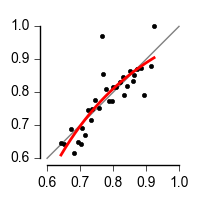

In [108]:
fig, ax = plt.subplots(figsize=(2,2))


# expectation line
x = np.linspace(.6, 1,10)
y = x
ax.plot(x,y, '-', color="gray")

# raw data
x = model.statistics.linear()
y = model.phenotypes
ax.plot(x, y, '.', color="k")

# nonlinear fit
modelx = np.linspace(min(x), max(x), 1000)
modely = power_transform(modelx, *model.parameters.get_params())
ax.plot(modelx, modely, '-', color="r", linewidth=2)

# styling
ax.spines["left"].set_bounds(0.6, 1)
ax.spines["bottom"].set_bounds(0.6, 1)
ax.axis([.58,1.05,.58,1.05])
prettify(ax)

In [109]:
fig.savefig("img/panel-a.svg", format="svg")

# Linear transform

In [96]:
phenotypes_ = reverse_function(model.phenotypes, *model.parameters.get_params())

# Fit with high-order epistasis model
linear = LinearEpistasisModel.from_gpm(model, model_type="global")
linear.phenotypes = phenotypes_
linear.fit()

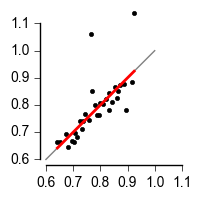

In [100]:
fig, ax = plt.subplots(figsize=(2,2))

# expectation line
x = np.linspace(.6, 1,10)
y = x
ax.plot(x,y, '-', color="gray")

# raw data
x = model.statistics.linear()
y = phenotypes_
ax.plot(x, y, '.', color="k")

# nonlinear fit
modelx = np.linspace(min(x), max(x), 1000)
modely = modelx
ax.plot(modelx, modely, '-', color="r", linewidth=2)

# styling
ax.spines["left"].set_bounds(0.6, 1.1)
ax.spines["bottom"].set_bounds(0.6, 1.1)
ax.axis([.58,1.15,.58,1.15])
prettify(ax)
fig.savefig("img/panel-b.svg", format="svg")

(<matplotlib.figure.Figure at 0x10ccdaa20>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10cff2400>])

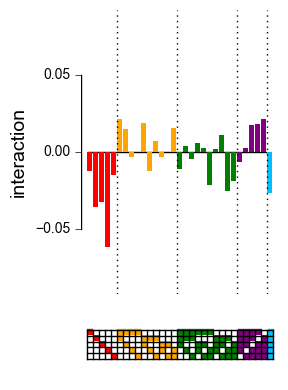

In [107]:
linear.plot.epistasis(figsize=(3,4), height_ratio=4)